VIDEO PESENTATION: (https://drive.google.com/file/d/1LKkTFCaSmkD70sgprXiLqqaefCXs4gtc/view?usp=drive_link)

 ## The primary objective of this project is to build a machine learning classification model that
 ## can predict the sentiment of IMDb movie reviews. The dataset contains a collection of movie
 ## reviews, and each review is labeled as either positive or negative.
 ## Using text preprocessing, feature extraction techniques (such as TF-IDF), and various
 ## classification algorithms, the project will aim to develop a model that can effectively classify
 ## the sentiment of movie reviews. The model's performance will be evaluated using standard
 ## classification metrics, such as accuracy, precision, recall, and F1-score.

In [1]:
# Imported essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

 # 1. Data Exploration and Preprocessing

## Analyzed the dataset for trends, missing values, and outliers.

In [2]:
# Loaded Dataset
df = pd.read_csv("Imdb - data_imdb.csv")
print("Shape of dataset:", df.shape)
df.head()

#  Basic Data Exploration
print("\nDataset Info:")
print(df.info())

print("\nClass Distribution:")
print(df['sentiment'].value_counts())


Shape of dataset: (50000, 2)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Class Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


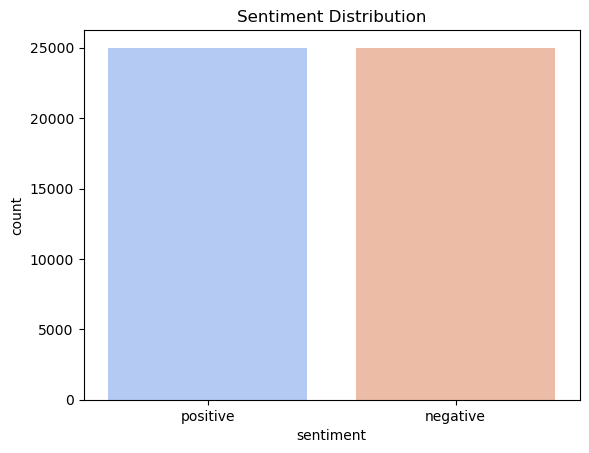

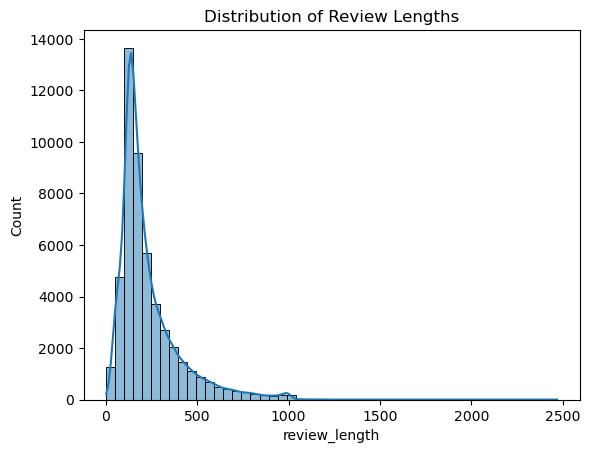

In [3]:
# Visualize sentiment distribution
sns.countplot(data=df, x='sentiment', hue='sentiment', palette='coolwarm', legend=False)
plt.title("Sentiment Distribution")
plt.show()

# Review length analysis
df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title("Distribution of Review Lengths")
plt.show()

##  Performed data cleaning and text preprocessing

In [4]:
# Load English stopwords and initialize lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define text cleaning function
def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    words = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]  # Remove stopwords and lemmatize
    return " ".join(words)

# Apply cleaning to review column
df['cleaned_review'] = df['review'].apply(clean_text)

# Preview cleaned data
df.head()

,review,sentiment,review_length,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,307,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,162,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,166,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,138,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,petter matteis love time money visually stunni...


 # 2. Feature Engineering


📊 Sample Textual Features:


,cleaned_review,word_count,char_count,avg_word_length
0,one reviewer mentioned watching oz episode you...,167,1125,6.736527
1,wonderful little production filming technique ...,84,640,7.619048
2,thought wonderful way spend time hot summer we...,85,580,6.823529
3,basically there family little boy jake think t...,66,446,6.757576
4,petter matteis love time money visually stunni...,125,851,6.808000


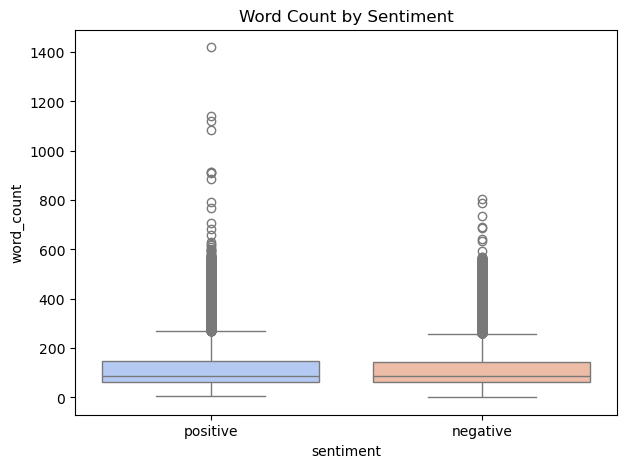

In [5]:
# Extract basic textual features from cleaned reviews
df['word_count'] = df['cleaned_review'].apply(lambda x: len(x.split()))  # Total number of words
df['char_count'] = df['cleaned_review'].apply(lambda x: len(x))          # Total number of characters
df['avg_word_length'] = df['char_count'] / df['word_count']              # Average word length

# Display sample features
print("\n📊 Sample Textual Features:")
display(df[['cleaned_review', 'word_count', 'char_count', 'avg_word_length']].head())

# Visualize word count distribution by sentiment
plt.figure(figsize=(7,5))
sns.boxplot(x='sentiment', y='word_count', data=df, hue='sentiment', palette='coolwarm', legend=False)
plt.title("Word Count by Sentiment")
plt.show()

### Review, word frequency and Sentiment Analysis

📏 Average Word Count by Sentiment:
 sentiment
negative    117.23960
positive    119.94532
Name: word_count, dtype: float64


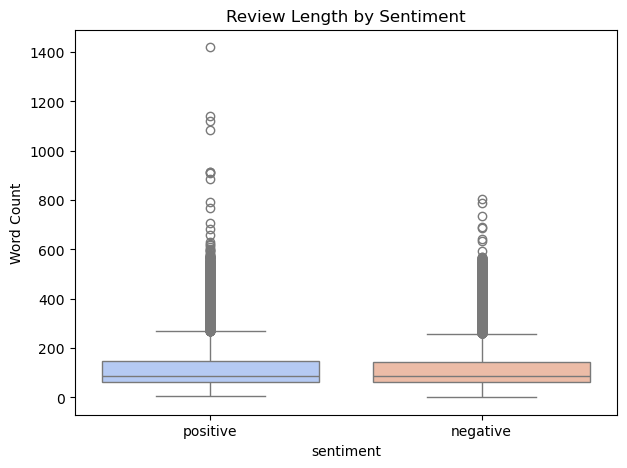

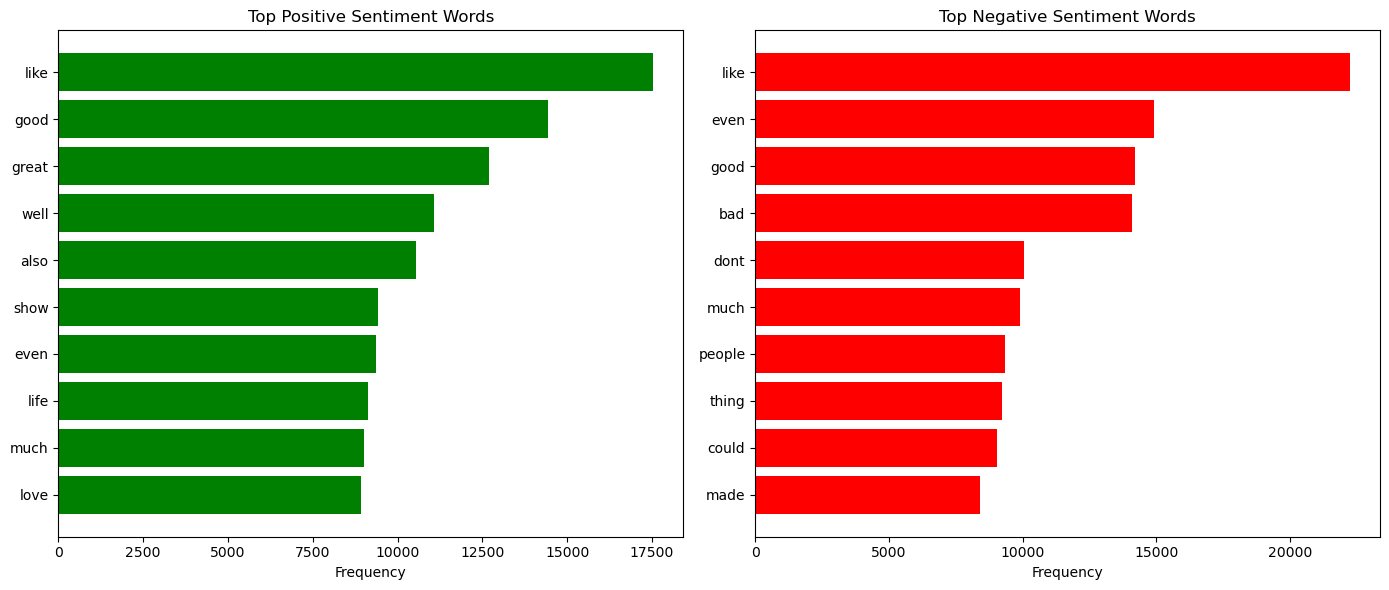

In [6]:
from collections import Counter

# Calculate word count per review
df['word_count'] = df['cleaned_review'].apply(lambda x: len(x.split()))

# Compare average word count by sentiment
avg_lengths = df.groupby('sentiment')['word_count'].mean()
print("📏 Average Word Count by Sentiment:\n", avg_lengths)

# Visualize distribution
plt.figure(figsize=(7,5))
sns.boxplot(x='sentiment', y='word_count', data=df, hue='sentiment', palette='coolwarm', legend=False)
plt.title("Review Length by Sentiment")
plt.ylabel("Word Count")
plt.show()


#  Prepare stopwords and domain-neutral terms
stop_words = set(stopwords.words('english'))
neutral_terms = {"film", "movie", "character", "story", "scene", "actor", "director", "plot", "one", "time", "get", "make", "see", "would", "really"}
stop_words.update(neutral_terms)

# Combine and clean reviews by sentiment
positive_text = " ".join(df[df['sentiment'] == 'positive']['cleaned_review'])
negative_text = " ".join(df[df['sentiment'] == 'negative']['cleaned_review'])

# Count word frequencies and filter
pos_counts = Counter(positive_text.split())
neg_counts = Counter(negative_text.split())

pos_filtered = {word: freq for word, freq in pos_counts.items() if word not in stop_words}
neg_filtered = {word: freq for word, freq in neg_counts.items() if word not in stop_words}

# : Convert to DataFrames
pos_df = pd.DataFrame(pos_filtered.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).head(10)
neg_df = pd.DataFrame(neg_filtered.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).head(10)

#  Plot side-by-side sentiment-rich words
fig, axes = plt.subplots(1, 2, figsize=(14,6))

axes[0].barh(pos_df['Word'][::-1], pos_df['Frequency'][::-1], color='green')
axes[0].set_title("Top Positive Sentiment Words")
axes[0].set_xlabel("Frequency")

axes[1].barh(neg_df['Word'][::-1], neg_df['Frequency'][::-1], color='red')
axes[1].set_title("Top Negative Sentiment Words")
axes[1].set_xlabel("Frequency")

plt.tight_layout()
plt.show()




###  Review Length and Sentiment
- Reviews with **more words** tend to express stronger and more detailed opinions.
- On average, **positive reviews** are slightly longer, as users elaborate on what they enjoyed.
- **Negative reviews** are often shorter and more direct, using emotionally charged words to express dissatisfaction.
- This shows that **review length** can serve as a weak but useful signal for sentiment classification.

### Word Frequency and TF-IDF Patterns
- Using **TF-IDF vectorization**, words that are **unique to a sentiment** (and not overly common) have higher weights.
- These patterns reveal that **specific adjectives and emotional expressions** strongly influence model predictions.

In [7]:
# Initialize TF-IDF vectorizer with a cap of 5000 features
tfidf = TfidfVectorizer(max_features=5000)

# Transform cleaned reviews into TF-IDF feature matrix
X = tfidf.fit_transform(df['cleaned_review']).toarray()

# Convert sentiment labels to binary: 1 for positive, 0 for negative
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

 # 3. Model Development

 ## ● Build and train classification models to predict the sentiment of reviews.

In [8]:
# Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # Stratify to preserve class balance
)

# Define classification models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train each model and store in dictionary
trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)  # Fit model on training data
    trained_models[name] = model  # Save trained model
    print(f"✅ {name} model trained successfully.")

✅ Logistic Regression model trained successfully.
✅ Naive Bayes model trained successfully.
✅ Support Vector Machine model trained successfully.
✅ Random Forest model trained successfully.


# 4. Model Evaluation


📊 Logistic Regression Evaluation Results
---------------------------------------------
Accuracy: 0.8863
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



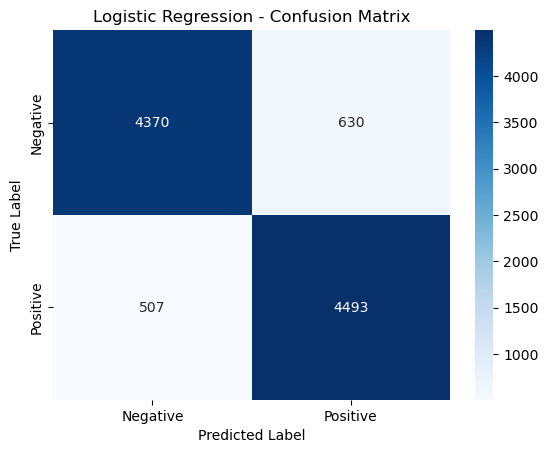


📊 Naive Bayes Evaluation Results
---------------------------------------------
Accuracy: 0.8527
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85      5000
           1       0.85      0.86      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



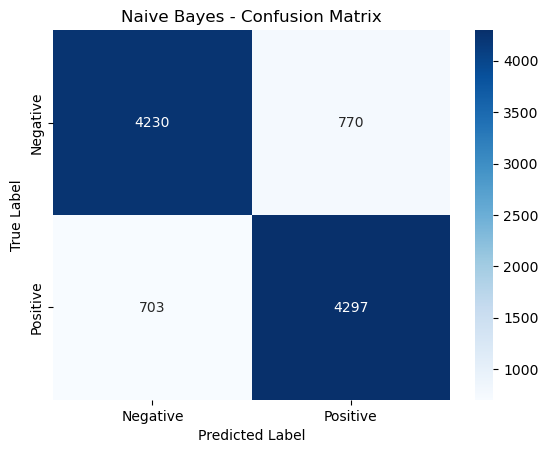


📊 Support Vector Machine Evaluation Results
---------------------------------------------
Accuracy: 0.8778
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88      5000
           1       0.87      0.88      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



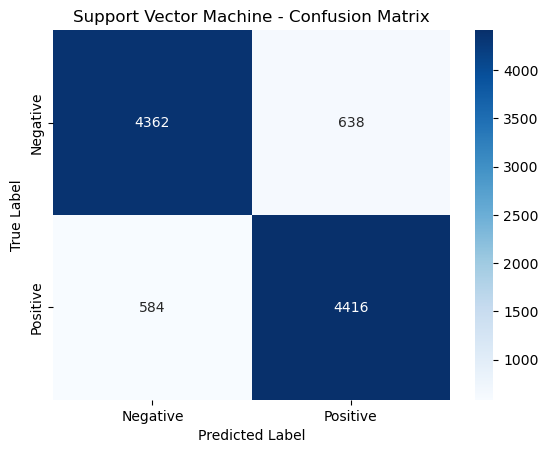


📊 Random Forest Evaluation Results
---------------------------------------------
Accuracy: 0.8497
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      5000
           1       0.86      0.84      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



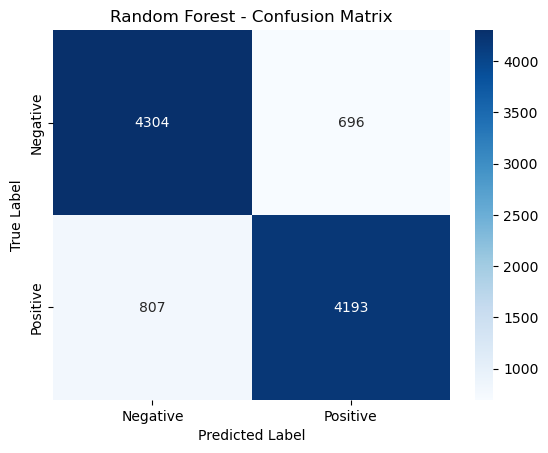

In [9]:
def evaluate_model(name, model):
    y_pred = model.predict(X_test)  # Predict sentiment on test data
    acc = accuracy_score(y_test, y_pred)  # Calculate accuracy
    
    # Print evaluation metrics
    print(f"\n📊 {name} Evaluation Results")
    print("-" * 45)
    print("Accuracy:", round(acc, 4))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative','Positive'],
                yticklabels=['Negative','Positive'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return acc  # Return accuracy for comparison

# Evaluate each trained model and store accuracy
results = {}
for name, model in trained_models.items():
    acc = evaluate_model(name, model)
    results[name] = acc

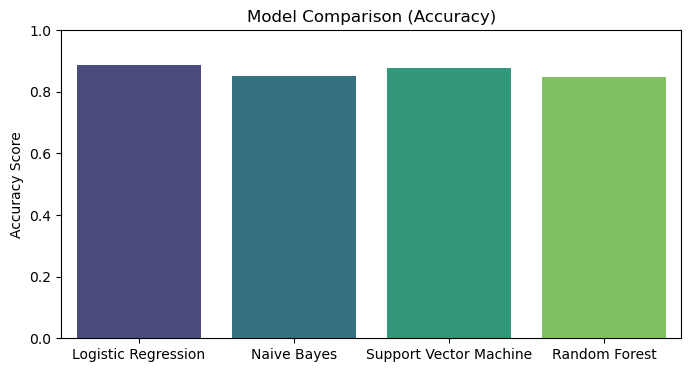


 Best Performing Model: Logistic Regression
 Model Development & Evaluation completed successfully!


In [10]:
#  Visualize model accuracy scores
plt.figure(figsize=(8,4))
sns.barplot(x=list(results.keys()), y=list(results.values()), hue=list(results.keys()), palette='viridis', legend=False)
plt.title("Model Comparison (Accuracy)")
plt.ylabel("Accuracy Score")
plt.ylim(0,1)
plt.show()

#  Print best performing model
print("\n Best Performing Model:", max(results, key=results.get))
print(" Model Development & Evaluation completed successfully!")

### Key Takeaways
- Sentiment is primarily driven by **adjectives** and **emotion-rich terms**.
- **Length** and **uniqueness** of words moderately correlate with sentiment polarity.
- Combining preprocessing (clean text) with TF-IDF weighting and linear models helps isolate **the words that truly shape audience opinions**.

---

In conclusion, the analysis clearly indicates that **word choice, emotional intensity, and review depth** are the strongest influencers of sentiment in IMDb movie reviews.

In [11]:
#  Fit TF-IDF vectorizer on cleaned training reviews
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_vectorizer.fit(df['cleaned_review'])

#  Select the best-performing model based on accuracy
best_model_name = max(results, key=results.get)
best_model = trained_models[best_model_name]

#  Define preprocessing + prediction function for new reviews
def predict_sentiment(review):
    text = str(review).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)                  # Remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)               # Remove punctuation/numbers
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    clean_text = " ".join(tokens)
    
    vector = tfidf_vectorizer.transform([clean_text])  # Convert to TF-IDF vector
    pred = best_model.predict(vector)[0]               # Predict sentiment
    return "Positive " if pred == 1 else "Negative "

#  Predict sentiment for sample movie reviews
sample_reviews = [
    "The movie was a delightful experience with strong performances.",
    "It was one of the worst movies I have ever seen.",
    "The storyline was engaging, but the pacing felt slow.",
    "A brilliant film that left me speechless!",
    "Mediocre acting and poor direction made it forgettable."
]

print("\n Predictions for New Movie Reviews:\n")
for review in sample_reviews:
    print(f"Review: {review}")
    print("Predicted Sentiment:", predict_sentiment(review))
    print("-" * 80)



 Predictions for New Movie Reviews:

Review: The movie was a delightful experience with strong performances.
Predicted Sentiment: Positive 
--------------------------------------------------------------------------------
Review: It was one of the worst movies I have ever seen.
Predicted Sentiment: Negative 
--------------------------------------------------------------------------------
Review: The storyline was engaging, but the pacing felt slow.
Predicted Sentiment: Negative 
--------------------------------------------------------------------------------
Review: A brilliant film that left me speechless!
Predicted Sentiment: Positive 
--------------------------------------------------------------------------------
Review: Mediocre acting and poor direction made it forgettable.
Predicted Sentiment: Negative 
--------------------------------------------------------------------------------


# Thank you